In [ ]:
# https://drive.google.com/file/d/1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd/view?usp=sharing - google drive link
# Download the file using gdown
!gdown --id 1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd
From (redirected): https://drive.google.com/uc?id=1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd&confirm=t&uuid=c0ece604-c3f7-4703-a417-af765f9dc2a8
To: /content/validation_depth_8bit_3ch.zip
100% 103M/103M [00:02<00:00, 44.2MB/s]


In [2]:
!unzip validation_depth_8bit_3ch.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_depth_8bit_3ch/tomato/tomato_6_2_226_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_6_2_226_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_8_1_226_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_8_1_226_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_8_1_231_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_8_1_231_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_2_1_201_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_2_1_201_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_8_2_6_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_8_2_6_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_2_1_1_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomat

In [3]:
!pip install torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # imagenet mean and std
    #                      std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.3762, 0.3762, 0.3762],  # our dataset mean/std
                         std=[0.2760, 0.2760, 0.2760])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3762, 0.3762, 0.3762],
                         std=[0.2760, 0.2760, 0.2760])
])

In [18]:
# 4. Load dataset and split indices
data_dir = 'validation_depth_8bit_3ch'
full_dataset = datasets.ImageFolder(root=data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Get shuffled indices for reproducibility
indices = list(range(len(full_dataset)))
random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

#5. Split using Subset
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# 6. Assign transforms afterwards
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [19]:
# Print dimensions of a few images from the training set
print("\nTraining set image dimensions:")
for images, labels in train_loader:
    for i, img in enumerate(images[:2]):  # Print dimensions of the first 2 images
        print(f"Image {i + 1} dimensions: {img.shape}")
    break  # Exit after processing the first batch

# Print dimensions of a few images from the validation set
print("\nValidation set image dimensions:")
for images, labels in val_loader:
    for i, img in enumerate(images[:2]):  # Print dimensions of the first 2 images
        print(f"Image {i + 1} dimensions: {img.shape}")
    break  # Exit after processing the first batch

    # Get size of train and validation sets
train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Training set size: {train_size:,}")
print(f"Validation set size: {val_size:,}")


Training set image dimensions:
Image 1 dimensions: torch.Size([3, 224, 224])
Image 2 dimensions: torch.Size([3, 224, 224])

Validation set image dimensions:
Image 1 dimensions: torch.Size([3, 224, 224])
Image 2 dimensions: torch.Size([3, 224, 224])
Training set size: 33,501
Validation set size: 8,376


In [ ]:
# 7. Load and modify pretrained ResNet50 (a common choice)
import torch.nn as nn
from torchvision import models

# Load a pretrained ResNet50 model
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers (e.g., the last layer of the convolutional blocks)
for param in model.fc.parameters():
    param.requires_grad = True

# Unfreeze the last convolutional block (layer4 in ResNet50)
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the classifier (fully connected layer) to match the number of classes
# The input features for the classifier of ResNet50 is 2048
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.4),
    nn.Linear(256, 51)  # Final output layer for 51 classes
)


model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 25,884,275
Trainable parameters: 17,340,979
Frozen parameters: 8,543,296


In [22]:
# 8. Optimizer and Loss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4  # L2 regularization
)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

In [23]:
num_epochs = 20

train_loss_list = []
val_loss_list = []
train_top1_list = []
train_top5_list = []
val_top1_list = []
val_top5_list = []

best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Top-1
        _, predicted = torch.max(outputs.data, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

        total_train += labels.size(0)

    train_top1_acc = correct_top1 / total_train * 100
    train_top5_acc = correct_top5 / total_train * 100
    avg_train_loss = train_loss / total_train

    train_loss_list.append(avg_train_loss)
    train_top1_list.append(train_top1_acc)
    train_top5_list.append(train_top5_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Top-1
            _, predicted = torch.max(outputs.data, 1)
            correct_top1 += (predicted == labels).sum().item()

            # Top-5
            top5_preds = torch.topk(outputs, 5, dim=1).indices
            correct_top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

            total_val += labels.size(0)

    val_top1_acc = correct_top1 / total_val * 100
    val_top5_acc = correct_top5 / total_val * 100
    avg_val_loss = val_loss / total_val

    val_loss_list.append(avg_val_loss)
    val_top1_list.append(val_top1_acc)
    val_top5_list.append(val_top5_acc)

    # Scheduler step
    scheduler.step(val_top1_acc)

    print(f"Epoch {epoch + 1}")
    print(f"Top-1 Train Accuracy: {train_top1_acc:.2f}% --- Train Loss: {avg_train_loss:.4f}  |  Top-5 Train Accuracy: {train_top5_acc:.2f}%")
    print(f"Top-1 Val Accuracy:   {val_top1_acc:.2f}% --- Val Loss:   {avg_val_loss:.4f}  |  Top-5 Val Accuracy:   {val_top5_acc:.2f}%\n")

    # Save best model
    if val_top1_acc > best_val_accuracy:
        best_val_accuracy = val_top1_acc
        torch.save(model.state_dict(), 'best_model.pth')

print("Training Complete!")

Epoch 1
Top-1 Train Accuracy: 9.86% --- Train Loss: 3.7086  |  Top-5 Train Accuracy: 27.52%
Top-1 Val Accuracy:   33.08% --- Val Loss:   3.0442  |  Top-5 Val Accuracy:   64.84%



Epoch 2
Top-1 Train Accuracy: 28.72% --- Train Loss: 2.9101  |  Top-5 Train Accuracy: 58.08%
Top-1 Val Accuracy:   44.17% --- Val Loss:   2.4204  |  Top-5 Val Accuracy:   78.15%



Epoch 3
Top-1 Train Accuracy: 40.71% --- Train Loss: 2.4079  |  Top-5 Train Accuracy: 72.97%
Top-1 Val Accuracy:   51.81% --- Val Loss:   2.0099  |  Top-5 Val Accuracy:   85.06%



Epoch 4
Top-1 Train Accuracy: 49.26% --- Train Loss: 2.0523  |  Top-5 Train Accuracy: 81.37%
Top-1 Val Accuracy:   58.39% --- Val Loss:   1.6983  |  Top-5 Val Accuracy:   88.75%



Epoch 5
Top-1 Train Accuracy: 55.50% --- Train Loss: 1.7836  |  Top-5 Train Accuracy: 86.19%
Top-1 Val Accuracy:   62.85% --- Val Loss:   1.4647  |  Top-5 Val Accuracy:   91.52%



Epoch 6
Top-1 Train Accuracy: 60.51% --- Train Loss: 1.5642  |  Top-5 Train Accuracy: 89.65%
Top-1 Val Accuracy:   67.32% --- Val Loss:   1.2837  |  Top-5 Val Accuracy:   93.14%



Epoch 7
Top-1 Train Accuracy: 64.87% --- Train Loss: 1.3862  |  Top-5 Train Accuracy: 92.15%
Top-1 Val Accuracy:   70.11% --- Val Loss:   1.1344  |  Top-5 Val Accuracy:   94.50%



Epoch 8
Top-1 Train Accuracy: 68.53% --- Train Loss: 1.2398  |  Top-5 Train Accuracy: 93.64%
Top-1 Val Accuracy:   73.09% --- Val Loss:   1.0114  |  Top-5 Val Accuracy:   95.57%



Epoch 9
Top-1 Train Accuracy: 71.40% --- Train Loss: 1.1077  |  Top-5 Train Accuracy: 94.91%
Top-1 Val Accuracy:   75.04% --- Val Loss:   0.9080  |  Top-5 Val Accuracy:   96.17%



Epoch 10
Top-1 Train Accuracy: 74.47% --- Train Loss: 0.9959  |  Top-5 Train Accuracy: 95.96%
Top-1 Val Accuracy:   76.90% --- Val Loss:   0.8235  |  Top-5 Val Accuracy:   96.85%



Epoch 11
Top-1 Train Accuracy: 77.02% --- Train Loss: 0.8944  |  Top-5 Train Accuracy: 96.75%
Top-1 Val Accuracy:   79.04% --- Val Loss:   0.7513  |  Top-5 Val Accuracy:   97.18%



Epoch 12
Top-1 Train Accuracy: 79.15% --- Train Loss: 0.8096  |  Top-5 Train Accuracy: 97.36%
Top-1 Val Accuracy:   80.46% --- Val Loss:   0.6869  |  Top-5 Val Accuracy:   97.68%



Epoch 13
Top-1 Train Accuracy: 81.45% --- Train Loss: 0.7203  |  Top-5 Train Accuracy: 97.93%
Top-1 Val Accuracy:   82.13% --- Val Loss:   0.6253  |  Top-5 Val Accuracy:   98.04%



Epoch 14
Top-1 Train Accuracy: 83.52% --- Train Loss: 0.6484  |  Top-5 Train Accuracy: 98.19%
Top-1 Val Accuracy:   83.52% --- Val Loss:   0.5764  |  Top-5 Val Accuracy:   98.39%



Epoch 15
Top-1 Train Accuracy: 85.32% --- Train Loss: 0.5811  |  Top-5 Train Accuracy: 98.73%
Top-1 Val Accuracy:   84.73% --- Val Loss:   0.5214  |  Top-5 Val Accuracy:   98.57%



Epoch 16
Top-1 Train Accuracy: 86.49% --- Train Loss: 0.5310  |  Top-5 Train Accuracy: 98.86%
Top-1 Val Accuracy:   85.71% --- Val Loss:   0.4879  |  Top-5 Val Accuracy:   98.81%



Epoch 17
Top-1 Train Accuracy: 88.02% --- Train Loss: 0.4759  |  Top-5 Train Accuracy: 99.13%
Top-1 Val Accuracy:   86.33% --- Val Loss:   0.4635  |  Top-5 Val Accuracy:   98.88%



Epoch 18
Top-1 Train Accuracy: 89.49% --- Train Loss: 0.4256  |  Top-5 Train Accuracy: 99.39%
Top-1 Val Accuracy:   87.40% --- Val Loss:   0.4284  |  Top-5 Val Accuracy:   99.04%



Epoch 19
Top-1 Train Accuracy: 90.50% --- Train Loss: 0.3876  |  Top-5 Train Accuracy: 99.48%
Top-1 Val Accuracy:   88.09% --- Val Loss:   0.4022  |  Top-5 Val Accuracy:   99.21%



Epoch 20
Top-1 Train Accuracy: 91.99% --- Train Loss: 0.3398  |  Top-5 Train Accuracy: 99.60%
Top-1 Val Accuracy:   88.48% --- Val Loss:   0.3840  |  Top-5 Val Accuracy:   99.31%

Training Complete!


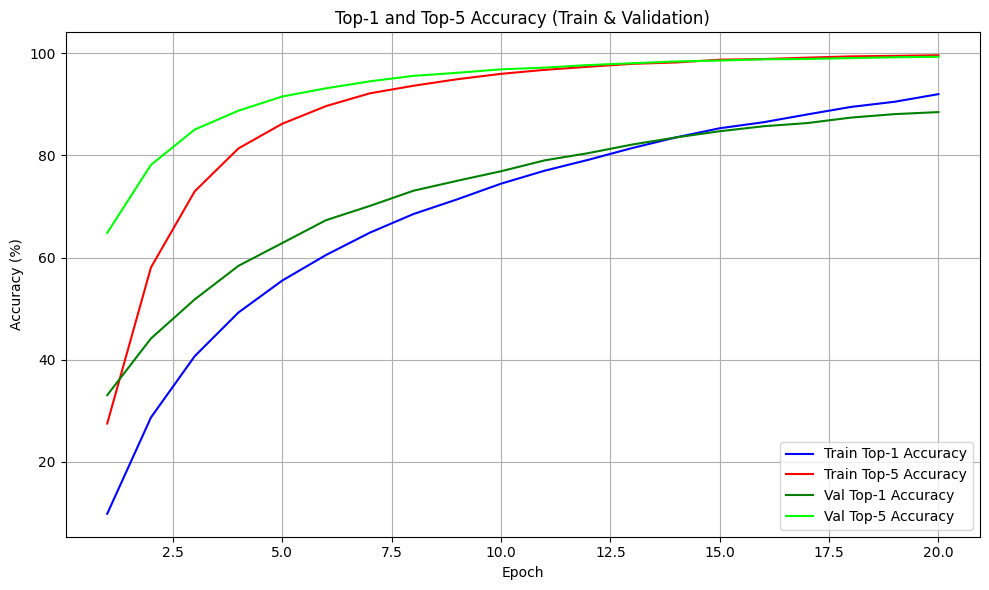

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_top1_list, label='Train Top-1 Accuracy', color='blue')
plt.plot(epochs, train_top5_list, label='Train Top-5 Accuracy', color='red')
plt.plot(epochs, val_top1_list, label='Val Top-1 Accuracy', color='green')
plt.plot(epochs, val_top5_list, label='Val Top-5 Accuracy', color='lime')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Accuracy (Train & Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

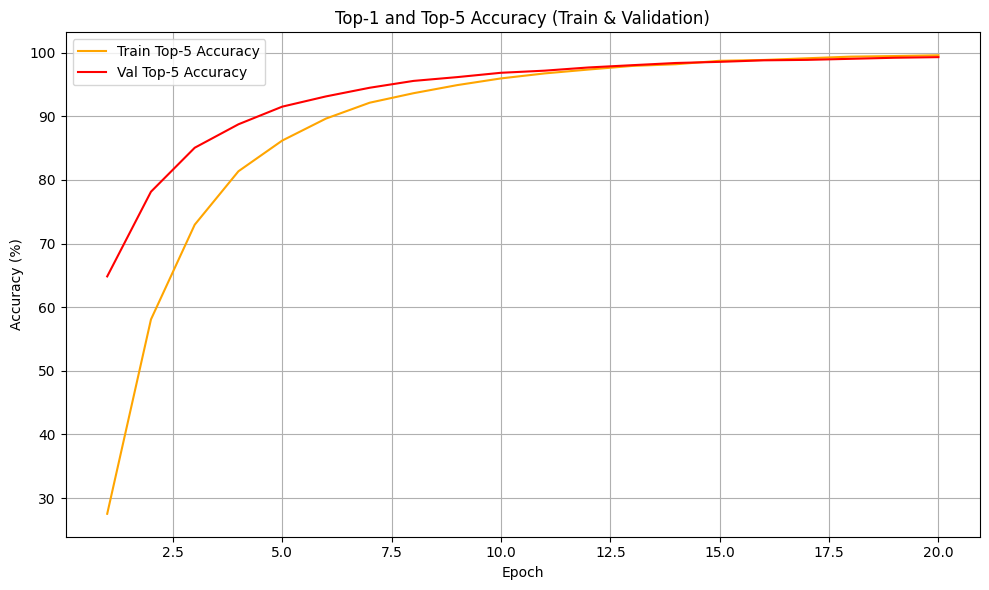

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_top1_list, label='Train Top-1 Accuracy', color='blue')
plt.plot(epochs, train_top5_list, label='Train Top-5 Accuracy', color='orange')
# plt.plot(epochs, val_top1_list, label='Val Top-1 Accuracy', color='green')
plt.plot(epochs, val_top5_list, label='Val Top-5 Accuracy', color='red')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Accuracy (Train & Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()